# Autoencoder

- The molecules for this notebook are a subset of the [QM09 dataset](https://www.nature.com/articles/sdata201422) by R. Ramakrishnan1, P. O. Dral, M. Rupp, and O. A. von Lilienfeld *Sci. Data*, **1**, 140022 (2014).

- A total of 17,834 small molecules with 18 atoms each were selected.

<img src="https://www.mdpi.com/sensors/sensors-21-04294/article_deploy/html/images/sensors-21-04294-g003.png" alt="Illustration of an Autoencoder" align="center" style="width: 500px;float: center;"/>



## 🧠 What are autoencoders

In this notebook we will learn how to implement an autoencoder. Autoencoders are a type of neural network designed to **learn efficient representations** of input data, typically for the purpose of **dimensionality reduction**, **feature learning**, or **denoising**. They consist of two main parts:

- **Encoder:** Maps the input data to a lower-dimensional latent representation.
- **Decoder:** Reconstructs the original data from the latent representation.

The training objective is to minimize the difference between the input and its reconstruction (often using mean squared error).

### 🎯 Why Use Autoencoders?

Autoencoders are useful in many scenarios, including:

- **Dimensionality Reduction**  
  Similar to PCA but capable of learning **nonlinear** transformations.

- **Feature Learning**  
  The latent space can capture abstract and task-relevant features that are useful for downstream models.

- **Data Denoising**  
  Denoising autoencoders can learn to reconstruct clean inputs from noisy versions, which is useful in preprocessing.

- **Anomaly Detection**  
  Autoencoders trained on normal data will struggle to reconstruct anomalies, leading to high reconstruction error — a useful signal for outlier detection.

- **Pretraining / Initialization**  
  Autoencoders can initialize deep networks (unsupervised pretraining), though this is now less common with modern optimizers and architectures.

### 🔍 Comparison to PCA

| Feature              | PCA                     | Autoencoder                  |
|---------------------|-------------------------|------------------------------|
| Linear/Nonlinear    | Linear only             | Can be nonlinear             |
| Interpretability    | High                    | Lower                        |
| Dimensionality      | Fixed transformation    | Learnable transformation     |
| Supervision         | Unsupervised            | Unsupervised                 |
| Flexibility         | Rigid (matrix-based)    | Flexible (deep learning)     |


# Libraries

In [1]:
import torch

import matplotlib.pyplot as plt

from pathlib          import Path
from torch.utils.data import DataLoader
#
### Import local libraries
#
from model_solution import AutoEncoder

## 1. Prepare data

Fisrt we need to load our dataset. We will use the `data_2d.pth` that includes the adjacency matrix for 17,834 small molecules. Our training data will be the adjacency matrix and the target will be the same matrix. For that, we will shuffle and dive our set into 80 % for training and the remaining 20 % for validation.

In [2]:
# Define data files
imhere  = Path.cwd()

# Set file name for the network
nnfile  = imhere/'network.pth'

# Load dataset
datapth = torch.load(imhere/'data_2d.pth')

# Shuffle data
idx     = torch.randperm(datapth.shape[0])
datapth = datapth[idx]

# Divide into 80% training and 20% testing
limit   = 20*len(idx)//100

print(f'train = {len(datapth[:-limit])}, '
      f'test = {len(datapth[-limit:])}, '
      f'test ratio = {len(datapth[-limit:])/len(datapth):.2f}')

train = 14268, test = 3566, test ratio = 0.20


## 2. Settings and hyperparameters

Our optimization algorithm is the ADAptive Moment estimation, [Adam](https://arxiv.org/pdf/1412.6980.pdf), that is based on stochastic gradient descent. We will need to define the **learning rate** and the **weight decay**. The learning rate is a hyperparameter that controls how much we are adjusting the weights of our network with respect to the loss gradient, whereas the weight decay is a regularization term that penalizes large weights

The number of **epochs** is the number of times the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters.

The **batch size** is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. The batch size is a compromise between the speed and the quality of the learning. The larger the batch size, the faster the learning, but the less accurate the updates. The smaller the batch size, the slower the learning, but the more accurate the updates.

Because the adjancency matrix contains only 0 and 1, we will use the Binary Cross Entropy **loss function**.
$$
\text{BCE} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right]
$$
where $N$ is the number of elements in the input tensor, $y_i$ is the target tensor, and $\hat{y}_i$ is the input tensor. The loss function takes the input tensor and the target tensor as arguments and returns the loss. The loss is the average of the binary cross entropy loss of all elements in the input tensor.

The training and testing data may be used in a loop function,

~~~
for batch in training: print(batch.shape)
~~~

each loop will automatically pass a total of `batch_size` samples to the neural network.

In [3]:
### Training parameters

learning_rate = 5e-3
weight_decay = 0.0

epochs       = 100
batch_size   = 492 # 1, 2, 3, 4, 6, 12, 29, 41, 58, 82, 87, 116, 123, 164, 174, 246, 348, 492, 1189, 2378, 3567, 4756, 7134, 14268
test_epoch   = 1

### Define neural network
network = AutoEncoder(input_nf = 18)

### Optimizer and Loss function
optimizer = torch.optim.Adam(params=network.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.BCELoss(reduction='mean')

### Training and testing data

training = DataLoader(datapth[:-limit], shuffle=True,  batch_size=batch_size)
testing  = DataLoader(datapth[-limit:], shuffle=False, batch_size=batch_size)

## 3. Training

We can now train our neural network for the total `epochs` we selected and testing it every `test_epoch` epochs.

Passing training data to the networks consists in five steps:

1. Set the gradients to zero, `optimizer.zero_grad()`.

2. Pass batch to the network, `output = network(batch)`.

3. Compute the loss, `loss = criterion(output, y)`.

4. Perform backward pass, `loss.backward()`.

5. Perform the optimization step, `optimizer.step()`.

Keep in mind that during testing you **DO NOT** want to update the gradients in your neural network. Otherwise you will leak testing information and your model will also learn from the testing set. To prevent this from happening, you need to use the `torch.no_grad()` context manager.  This will prevent the gradient from being updated. 

1,train,0.2932
1,test,0.1974
2,train,0.1929
2,test,0.1916
3,train,0.1902
3,test,0.1902
4,train,0.1838
4,test,0.1714
5,train,0.1657
5,test,0.1616
6,train,0.1586
6,test,0.1571
7,train,0.1528
7,test,0.1473
8,train,0.1406
8,test,0.1352
9,train,0.1278
9,test,0.1205
10,train,0.1136
10,test,0.1087
11,train,0.1035
11,test,0.1005
12,train,0.0964
12,test,0.0933
13,train,0.0883
13,test,0.0859
14,train,0.0832
14,test,0.0821
15,train,0.0796
15,test,0.0790
16,train,0.0739
16,test,0.0707
17,train,0.0666
17,test,0.0646
18,train,0.0609
18,test,0.0599
19,train,0.0567
19,test,0.0570
20,train,0.0545
20,test,0.0550
21,train,0.0516
21,test,0.0519
22,train,0.0487
22,test,0.0500
23,train,0.0472
23,test,0.0481
24,train,0.0448
24,test,0.0471
25,train,0.0426
25,test,0.0439
26,train,0.0395
26,test,0.0402
27,train,0.0368
27,test,0.0385
28,train,0.0354
28,test,0.0381
29,train,0.0342
29,test,0.0368
30,train,0.0329
30,test,0.0363
31,train,0.0322
31,test,0.0357
32,train,0.0316
32,test,0.0348
33,train,0.0305
33,test,0.

<function matplotlib.pyplot.show(close=None, block=None)>

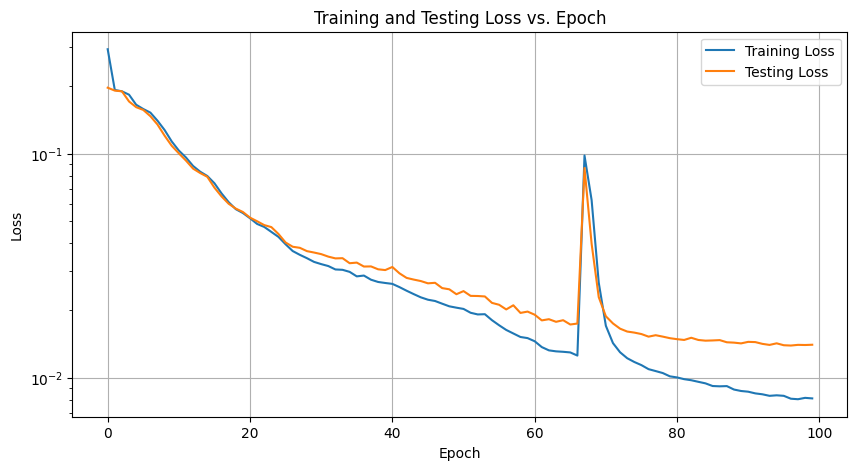

In [4]:
# Create arrays to store the training and testing loss for plotting
training_loss_print = []
testing_loss_print  = []

for epoch in range(epochs):

    training_loss = []
    testing_loss  = []
    
    # your code here for the training set
    for batch in training:
        optimizer.zero_grad()
        # Forward pass
        output = network(batch)
        # Compute loss
        loss = criterion(output, batch)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Store loss for this batch
        training_loss.append(loss)

    # Average loss for the epoch, store in loss
    loss = torch.mean(torch.stack(training_loss))

    print(f'{epoch+1},train,{loss:.4f}')
    
    if (epoch+1)%test_epoch == 0:
        # Save the training loss for plotting in a numpy array
        training_loss_print.append(loss.item())

        # your code here for the testing set
        for batch in testing:
            with torch.no_grad():
                # Forward pass
                output = network(batch)
            # Compute loss
            loss = criterion(output, batch)
            # Store loss for this batch
            testing_loss.append(loss)
        
        # Average loss for the epoch, store in loss
        loss = torch.mean(torch.stack(testing_loss))
        # Print loss
        print(f'{epoch+1},test,{loss:.4f}')
        # Save the testing loss for plotting using only the numeric value
        # (not the tensor)
        # Store loss for this batch
        testing_loss_print.append(loss.item())

# Save model
torch.save(network.state_dict(), nnfile)

# Plot the training and testing loss vs. epoch using a logscale for y
plt.figure(figsize=(10, 5))
plt.yscale('log')
plt.plot(training_loss_print, label='Training Loss')
plt.plot(testing_loss_print, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss vs. Epoch')
plt.legend()
plt.grid()
plt.show

## 5. Test the model

Choose a random sample from the test set to compare the original and reconstructed adjacency matrices.

idx = 1810
sample.shape = torch.Size([1, 18, 18])
Predicted adjacency matrix:
[[0.00000000e+00 1.00000000e+00 1.32132474e-08 3.62724628e-10
  1.89913510e-24 6.15381746e-10 8.06684497e-08 1.72320815e-05
  1.70080714e-08 1.30770044e-08 1.15728876e-30 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 1.00000000e+00 1.52468472e-03
  6.46452405e-11 4.55931913e-05 8.06941390e-02 1.12497981e-03
  9.99254405e-01 6.13722484e-12 1.17621232e-24 0.00000000e+00
  2.28446742e-24 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.64879630e-08 1.00000000e+00 0.00000000e+00 1.00000000e+00
  9.62970537e-11 8.50473256e-08 1.70853664e-03 6.00045241e-13
  5.16930653e-04 9.99988675e-01 1.22990314e-05 1.58757550e-22
  5.83858377e-30 1.91222382e-28 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.34681425e-39]
 [1.86671192e-10 9.91995330e-04 1.00000000e+00 0.00000000e+00
  1.00000000e+00 

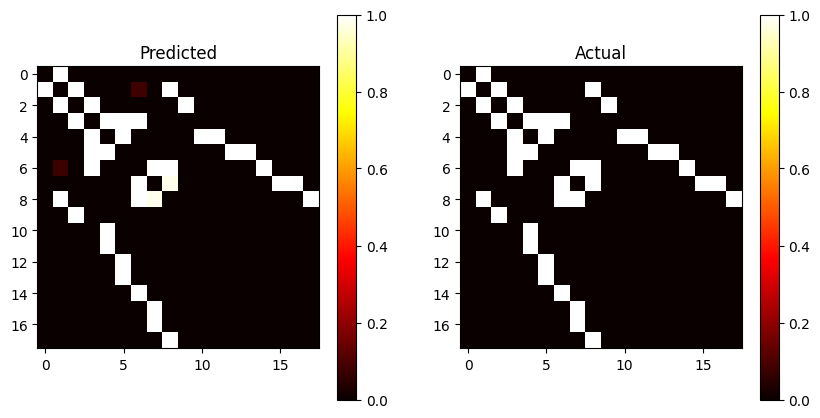

In [5]:
# Choose a random sample from the test set to compare the original and reconstructed adjacency matrices.

idx = torch.randint(0, len(datapth[-limit:]), (1,)).item()
print(f'idx = {idx}')
sample = datapth[-limit:][idx]
sample = sample.unsqueeze(0)
print(f'sample.shape = {sample.shape}')
output = network(sample)

# print the predicted and actual adjacency matrix
print(f'Predicted adjacency matrix:\n{output.squeeze().detach().numpy()}')
print(f'Actual adjacency matrix:\n{sample.squeeze().numpy()}')

# Plot the predicted and actual adjacency matrix
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(output.squeeze().detach().numpy(), cmap='hot', interpolation='nearest')
plt.title('Predicted')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(sample.squeeze().numpy(), cmap='hot', interpolation='nearest')
plt.title('Actual')
plt.colorbar()
plt.show()

Calculate the testing error and compare with the training error from above

In [6]:
# Compute the testing error
testing_loss = []
for batch in testing:
    with torch.no_grad():
        # Forward pass
        output = network(batch)
    # Compute loss
    loss = criterion(output, batch)
    # Store loss for this batch
    testing_loss.append(loss)

# Average loss for the epoch, store in loss
loss = torch.mean(torch.stack(testing_loss))
print(f'Testing loss: {loss:.4f}')

Testing loss: 0.0141
